In [77]:
import numpy as np
import rasterio 
from rasterio.plot import show
from scipy.spatial import cKDTree
from rasterio.enums import Resampling
import geopandas as gpd
import pandas as pd
import os 

direct_data ='C:\\Users\\Aubre_M\\Documents\\Fall 2020\\GIS Programming_ Automation\\geog_4092\\Week 6\\data\\data'
Pro_area = 'C:\\Users\\Aubre_M\\Documents\\Fall 2020\\GIS Programming_ Automation\\geog_4092\\Week 6\\data\\data\\protected_areas.tif'
Water_area = 'C:\\Users\\Aubre_M\\Documents\\Fall 2020\\GIS Programming_ Automation\\geog_4092\\Week 6\\data\\data\\water_bodies.tif'
Win_80 = 'C:\\Users\\Aubre_M\\Documents\\Fall 2020\\GIS Programming_ Automation\\geog_4092\\Week 6\\data\\data\\ws80m.tif'
Urban_area = 'C:\\Users\\Aubre_M\\Documents\\Fall 2020\\GIS Programming_ Automation\\geog_4092\\Week 6\\data\\data\\urban_areas.tif'
Slope = 'C:\\Users\\Aubre_M\\Documents\\Fall 2020\\GIS Programming_ Automation\\geog_4092\\Week 6\\data\\data\\slope.tif'
Trans_stations = 'C:\\Users\\Aubre_M\\Documents\\Fall 2020\\GIS Programming_ Automation\\geog_4092\\Week 6\\data\\data\\transmission_stations.txt'

W_col = int(11)
W_row = int(9)
mask = np.ones((W_row, W_col))

def moving_windows(d, mask):
    #d = np.where(d < 0, 0, d)
    #creates a movinging window of 11 by 9 creating a 99 km square 
    tempArr = np.zeros(d.shape)
    win_area = float(mask.sum())
    
    row_din = mask.shape[0]//2
    col_din = mask.shape[1]//2
    for row in range( row_din, d.shape[0] - row_din):
        for col in range(col_din, d.shape[1] - col_din):
            win = d[row - row_din: row + row_din + 1, 
                    col - col_din: col + col_din + 1]
            tempArr[row, col] = win.sum()
            
    
    return tempArr/win_area


In [78]:
#Protected Area criteria 
#Boolean criteria 1 
raster = rasterio.open(Pro_area)
data = raster.read(1)

Npro_area = moving_windows(data, mask)
#print(Npro_area)
#show(Npro_area)

Suit_pro_area = np.where(Npro_area < 0.05, 1, 0)
print('The number of sites where less than 5% of the site is within protected areas is ', Suit_pro_area.sum())
#show(Suit_pro_area)

The number of sites where less than 5% of the site is within protected areas is  1888929


In [79]:
#Water Area criteria  
#Boolean criteria 2
raster = rasterio.open(Water_area)
data = raster.read(1)

Nwater_area = moving_windows(data, mask)
#print(Nwater_area)
#show(Nwater_area)

suit_water_area = np.where(Nwater_area < 0.02, 1, 0)
print('The number of sites where less than 2% of land can be covered by water is ', suit_water_area.sum())
#show(Suit_Water_area)

The number of sites where less than 2% of land can be covered by water is  1960951


In [80]:
#Urban Area criteria
#Boolean criteria 3
raster = rasterio.open(Urban_area)
data = raster.read(1)

Nurban_area = moving_windows(data, mask)
#print(Nurban_area)
#show(Nurban_area)

Suit_urb_area = np.where(Nurban_area > 0, 0, 1)
print(' The number of sites where there are no urban areas is ', Suit_urb_area.sum())

 The number of sites where there are no urban areas is  1832741


In [81]:
#Slope Criteria 
#Boolena criteria 4 
raster = rasterio.open(Slope)
data = raster.read(1)
data = np.where(data < 0, 0, data)
NSlope_area = moving_windows(data, mask)
#print(NSlope_area)
#show(NSlope_area)

Suit_slope_area = np.where(NSlope_area < 15, 1, 0)
print('The number of sites where the average slope of less than 15 degrees is ', Suit_slope_area.sum())
#show(Suit_slope_area)

The number of sites where the average slope of less than 15 degrees is  1921753


In [82]:
#wind speed 80m Area criteria
#Boolean criteria 5 
raster = rasterio.open(Win_80)
data = raster.read(1)
meta = raster.meta
data = np.where(data < 0, 0, data)
#Nwin_area = np.zeros(data, np.float32)
Nwin_area = moving_windows(data, mask)
#print(Nwin_area)
#show(Nwin_area)

Suit_win_area = np.where(Nwin_area > 8.5, 1, 0)
print('The number of sites where the average wind speed is greater than 8.5m/s is ', Suit_win_area.sum())
#show(Suit_win_area) 
 

The number of sites where the average wind speed is greater than 8.5m/s is  2440


In [83]:
sum_area = Suit_pro_area + suit_water_area + Suit_urb_area + Suit_slope_area + Suit_win_area
suitable_areas = np.where(sum_area == 5, 1, 0)
print('Total number of suitable sites is ', suitable_areas.sum())
Suitarray = []
Suitarray.append(suitable_areas)
#print(Suitarray)

Total number of suitable sites is  425


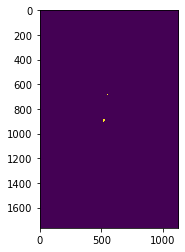

In [84]:
meta.update({'dtype': 'int16', 'nodata':0})
#with rasterio.open(Slope) as dataset:
with rasterio.open(os.path.join(f'.\\data\\suitable_areas.tif'), 'w', **meta) as data_tif:
                   data_tif.write(suitable_areas.astype('int16'), indexes = 1) 
                   
suit_sites = rasterio.open(os.path.join(f'.\\data\\suitable_areas.tif'))
suit_sites = suit_sites.read(1)
show (suit_sites)
#with rasterio.open(Slope) as dataset:
#    with rasterio.open(f'.\\data\\suitable_areas.tif', 'w', driver='GTiff', height=suitable_areas.shape[0],
#                        width=suitable_areas.shape[1], count=1, dtype= np.int32, crs= dataset.crs, 
#                        transform =dataset.transform, nodata= -9999) as data_tif:
#                        data_tif.write(suitable_areas) 

#suitable_areas.dtype
#dtype('int64')        
#show('suitable_areas.tif')
#suitable_areas.dtype
#dtype('int32')

In [85]:
with rasterio.open(f'.\\data\\suitable_areas.tif') as file: 
    bounds = file.bounds
    TopLeft = (bounds[0],bounds[3])
    LowRight = (bounds[2],bounds[1])
    cellsize = 1000
    x_coord = np.arange(float(TopLeft[0] + cellsize/2), float(LowRight[0]), float(cellsize))
    y_coord = np.arange(float(LowRight[1] + cellsize/2), float(TopLeft[1]), float(cellsize))
    x, y = np.meshgrid(x_coord,y_coord)
    coord = np.c_[x.flatten(), y.flatten()]



x_cs = []
y_cs = []
with open(Trans_stations) as coords:
    lines = coords.readlines()[1:]
    for l in lines:
        x,y = l.split(',')
        x_cs.append(float(x))
        y_cs.append(float(y))
    stations = np.vstack([x_cs,y_cs])
    stations = stations.T 
    

tree = cKDTree(coord)

dd, ii  = tree.query(stations, k=5)

print('The maximum distance to the closest transmission substation among all of the suitable sites is ' 
      +  str(dd.max()) + ' meters')
print('The maximum distance to the closest transmission substation among all of the suitable sites is ' 
      +  str(dd.min()) + ' meters')


The maximum distance to the closest transmission substation among all of the suitable sites is 1570.9460671079535 meters
The maximum distance to the closest transmission substation among all of the suitable sites is 13.400763750871537 meters
